# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, count, sum as Fsum
from pyspark.sql.types import IntegerType, DateType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
#Number of rows before cleaning
df.count()

286500

In [6]:
#Drop missing values
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [7]:
#Remove rows with empty userId
df = df.filter(df.userId != "")
df.count()

278154

In [8]:
#Number of users
df.select("userId").dropDuplicates().count()

225

In [9]:
# Number of sessions
df.select("sessionId").dropDuplicates().count()

2312

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [11]:
# create a list for churn users
churn_user_df = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_user_list = [user["userId"] for user in churn_user_df.collect()]

In [12]:
# create a column for churn
df_withchurn = df.withColumn("churn", df.userId.isin(churn_user_list))

In [13]:
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



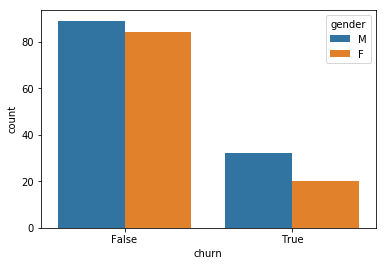

In [14]:
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

In [15]:
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

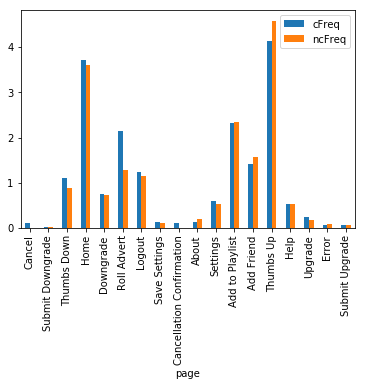

In [16]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")

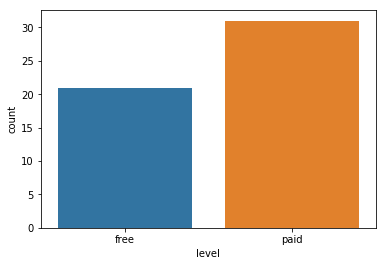

In [17]:
df_pd = df_withchurn.filter(df_withchurn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

In [18]:
df_valid_songs = df_withchurn.where(df_withchurn.song!='null').groupby(['churn','userId']) \
    .agg(count(df_withchurn.song).alias('SongsPlayed')).orderBy('churn').toPandas()

[]

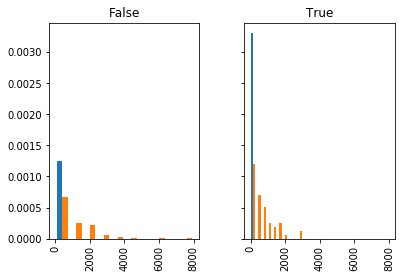

In [19]:
df_valid_songs.hist(['SongsPlayed'], by='churn', sharex=True, sharey=True,density=1)
plt.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f156c3004a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f156c13d240>], dtype=object)

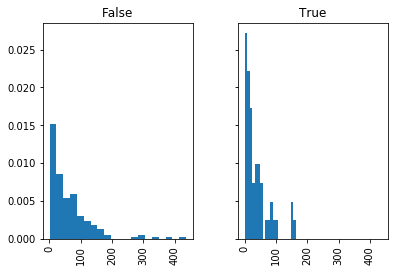

In [20]:
#investigate the average numbers of thumps-up and thumps-down by two groups.
df_valid_thumbsup = df_withchurn.where(df_withchurn.page=='Thumbs Up') \
    .groupby(['churn','userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('churn').toPandas()
df_valid_thumbsup.hist('ThumbsUps', by='churn', bins=20, sharex=True, sharey=True, density=1)

In [21]:
print('ThumbsUps for people who stay',df_valid_thumbsup[df_valid_thumbsup['churn']==False]['ThumbsUps'].mean())
print('ThumbsUps for people who leave',df_valid_thumbsup[df_valid_thumbsup['churn']==True]['ThumbsUps'].mean())

ThumbsUps for people who stay 62.8941176471
ThumbsUps for people who leave 37.18


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f156c0790b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1565fd4cc0>], dtype=object)

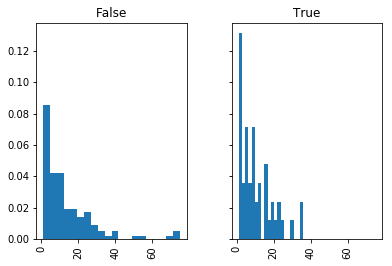

In [22]:
df_valid_thumbsdown = df_withchurn.where(df_withchurn.page=='Thumbs Down') \
    .groupby(['churn','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('churn').toPandas()
df_valid_thumbsdown.hist('ThumbsDowns', by='churn', bins=20, sharex=True, sharey=True, density=1)

In [23]:
print('ThumbsDowns for people who stay',df_valid_thumbsdown[df_valid_thumbsup['churn']==False]['ThumbsDowns'].mean())
print('ThumbsDowns for people who leave',df_valid_thumbsdown[df_valid_thumbsup['churn']==True]['ThumbsDowns'].mean())

ThumbsDowns for people who stay 12.7352941176
ThumbsDowns for people who leave 11.5454545455


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [24]:
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [25]:
song=udf(lambda x : int(x=='NextSong'), IntegerType())
home_visit=udf(lambda x : int(x=='Home'), IntegerType())
df_withchurn = df_withchurn.withColumn('date', get_day(col('ts')))

In [26]:
#difference in number of songs played between users who churned and didnt?
df_withchurn.filter(col('churn')==1).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()
df_withchurn.filter(col('churn')==0).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [27]:
#number of songs couldn't be played due to errors
df_withchurn.filter((df_withchurn.page=='Error')&(df_withchurn.churn==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

df_withchurn.filter((df_withchurn.page=='Error')&(df_withchurn.churn==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

+-------+------------------+
|summary|       count(page)|
+-------+------------------+
|  count|                30|
|   mean|1.0666666666666667|
| stddev|0.2537081317024624|
|    min|                 1|
|    max|                 2|
+-------+------------------+

+-------+-------------------+
|summary|        count(page)|
+-------+-------------------+
|  count|                200|
|   mean|                1.1|
| stddev|0.31702131247412063|
|    min|                  1|
|    max|                  3|
+-------+-------------------+



In [28]:
#ratio of those who cancelled subscriptions both free and paid
print(df_withchurn.filter((df_withchurn.page=='Cancellation Confirmation') & (df_withchurn.level=='paid')).count(),
df_withchurn.filter((df.page=='Cancellation Confirmation') & (df.level=='free')).count())

31 21


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
#Gender
df_gender = df_withchurn.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'], ['1', '0'], 'gender')
df_gender.withColumn('gender', df_gender.gender.cast("int"))

DataFrame[userId: string, gender: int]

In [30]:
df_gender.show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



In [31]:
#number of days since registration
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [32]:
user_reg_days.show()

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
|     7| 72.77818287037037|
|    15|56.513576388888886|
|    54|110.75168981481481|
|   155|23.556018518518517|
|100014| 85.08340277777778|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|   101|        53.9659375|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|100021| 64.73886574074074|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|   112| 87.46262731481481|
+------+------------------+
only showing top 20 rows



In [33]:
#Number of songs played
df_songs = df_withchurn.where(df_withchurn.song!='null').groupby('userId') \
    .agg(count(df_withchurn.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])

In [34]:
df_songs.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [35]:
#Average time per session
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime")).sort("userId")

In [36]:
user_session_time_stat.show()

+------+------------------+
|userId|    avgSessionTime|
+------+------------------+
|    10|459.74722222222226|
|   100| 316.5190476190476|
|100001|148.15833333333333|
|100002|201.18333333333334|
|100003| 99.11666666666667|
|100004|185.98650793650793|
|100005|120.18666666666668|
|100006| 93.43333333333334|
|100007|189.41111111111113|
|100008| 528.2527777777779|
|100009|211.96166666666667|
|100010|154.48333333333332|
|100011| 44.38333333333333|
|100012|271.43809523809523|
|100013|329.99880952380954|
|100014| 184.8138888888889|
|100015|278.59444444444443|
|100016|265.40416666666664|
|100017|199.26666666666668|
|100018|193.18730158730162|
+------+------------------+
only showing top 20 rows



In [37]:
#pick the number of singers user has listened
df_singers = df_withchurn.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg(count(df_withchurn.artist).alias('SingersListened')).orderBy('userId') \
    .select(['userId','SingersListened'])

In [38]:
df_singers.show()

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
|100009|            442|
|100010|            252|
|100011|             11|
|100012|            397|
|100013|            826|
|100014|            233|
|100015|            627|
|100016|            431|
|100017|             51|
|100018|            780|
+------+---------------+
only showing top 20 rows



In [39]:
#Number of songs per session
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [40]:
user_session_songs_avg.show()

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
|100004|              47.1|
|100005|              38.5|
|100006|              26.0|
|100007|              47.0|
|100008|128.66666666666666|
|100009|              51.8|
|100010|39.285714285714285|
|100011|              11.0|
|100012| 79.33333333333333|
|100013|              87.0|
|100014|42.833333333333336|
|100015| 66.66666666666667|
|100016|             66.25|
|100017|              52.0|
|100018|              50.1|
+------+------------------+
only showing top 20 rows



In [41]:
#Number of sessions
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount").sort('userID')

In [42]:
user_session_count.show()

+------+------------+
|userId|sessionCount|
+------+------------+
|    10|           6|
|   100|          35|
|100001|           4|
|100002|           4|
|100003|           2|
|100004|          21|
|100005|           5|
|100006|           1|
|100007|           9|
|100008|           6|
|100009|          10|
|100010|           7|
|100011|           1|
|100012|           7|
|100013|          14|
|100014|           6|
|100015|          12|
|100016|           8|
|100017|           1|
|100018|          21|
+------+------------+
only showing top 20 rows



In [43]:
#Number of friends
numFriends = df_withchurn.filter(df_withchurn.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends').sort('userId')

In [44]:
numFriends.show()

+------+----------+
|userId|numFriends|
+------+----------+
|    10|        12|
|   100|        49|
|100001|         2|
|100002|         1|
|100004|        19|
|100005|         3|
|100006|         4|
|100007|        17|
|100008|        17|
|100009|         7|
|100010|         4|
|100012|         2|
|100013|        28|
|100014|         6|
|100015|        14|
|100016|        13|
|100018|        23|
|100019|         2|
|100021|         7|
|100022|        11|
+------+----------+
only showing top 20 rows



In [45]:
df_final = df_withchurn.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in [df_gender, user_reg_days, df_songs, user_session_time_stat, df_singers, user_session_songs_avg,user_session_count, numFriends]:
    df_final = df_final.join(feature,'userId')

In [46]:
df_final.show()

+------+-----+------+------------------+-----------+------------------+---------------+------------------+------------+----------+
|userId|churn|gender|            regDay|SongsPlayed|    avgSessionTime|SingersListened|   avgSessionSongs|sessionCount|numFriends|
+------+-----+------+------------------+-----------+------------------+---------------+------------------+------------+----------+
|100010|false|     1| 55.64365740740741|        275|154.48333333333332|            252|39.285714285714285|           7|         4|
|200002|false|     0| 70.07462962962963|        387|266.40000000000003|            339|              64.5|           6|         4|
|   124|false|     1|131.55591435185184|       4079| 578.9942528735633|           2232|145.67857142857142|          29|        74|
|    51| true|     0|19.455844907407407|       2111| 872.3566666666666|           1385|             211.1|          10|        28|
|     7|false|     0| 72.77818287037037|        150| 87.64047619047619|            

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [47]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
| true|   44|
|false|  162|
+-----+-----+



In [48]:
#df_final.write.save('df_final.csv', format="csv", header=True)

In [49]:
df_final = spark.read.csv('df_final.csv', header=True)

In [50]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [51]:
df_final.dtypes

[('userId', 'string'),
 ('churnNum', 'float'),
 ('genderNum', 'float'),
 ('regDayNum', 'float'),
 ('SongsPlayedNum', 'float'),
 ('avgSessionTimeNum', 'float'),
 ('SingersListenedNum', 'float'),
 ('avgSessionSongsNum', 'float'),
 ('sessionCountNum', 'float'),
 ('numFriendsNum', 'float')]

In [52]:
df_final.show(5)

+------+--------+---------+---------+--------------+-----------------+------------------+------------------+---------------+-------------+
|userId|churnNum|genderNum|regDayNum|SongsPlayedNum|avgSessionTimeNum|SingersListenedNum|avgSessionSongsNum|sessionCountNum|numFriendsNum|
+------+--------+---------+---------+--------------+-----------------+------------------+------------------+---------------+-------------+
|   126|     0.0|      0.0|62.095695|        2577.0|          357.505|            1643.0|          88.86207|           30.0|         33.0|
|   131|     0.0|      0.0|120.89992|        1564.0|        340.22455|            1100.0|              92.0|           19.0|         26.0|
|   140|     0.0|      1.0|80.605125|        5664.0|        328.06525|            2819.0|         84.537315|           71.0|        143.0|
|    17|     1.0|      1.0|13.099016|         927.0|           601.25|             741.0|         132.42857|            7.0|         12.0|
|   103|     1.0|      1.0|

In [53]:
assembler = VectorAssembler(inputCols=df_final.columns[2:], outputCol="NumFeatures")
data = assembler.transform(df_final)

In [54]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [55]:
data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))

In [56]:
train, validation = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [57]:
stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
stratified_train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   40|
|  0.0|   46|
+-----+-----+



In [58]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(stratified_train)

In [59]:
#cvModel_lr.save('cvModel_lr.model')

In [60]:
cvModel_lr.avgMetrics

[0.6016522058188725,
 0.6697386425834702,
 0.6906335522714833,
 0.6016522058188725,
 0.6697386425834702,
 0.6677539682539683,
 0.6016522058188725,
 0.6677539682539683,
 0.7119285714285714,
 0.6016522058188725,
 0.6978706004140786,
 0.7136137949543747]

In [61]:
results = cvModel_lr.transform(validation)

In [62]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   40|
|  0.0|  144|
+-----+-----+



In [63]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

0.6
0.75
0.6666666666666665


In [64]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)

In [65]:
#cvModel_dt.save('cvModel_dt.model')

In [66]:
cvModel_dt.avgMetrics

[0.7166456421471361,
 0.7618805577903952,
 0.6874086536756899,
 0.7326531580009157,
 0.7212916329104463,
 0.7212916329104463,
 0.7176519019708756,
 0.7166456421471361,
 0.7712471158821814,
 0.7007283338780541,
 0.7046657546262916,
 0.6897553703358787,
 0.6954679048773608,
 0.6915372730873912]

In [67]:
results = cvModel_dt.transform(validation)

In [68]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

0.5
0.75
0.6


# Conclusion
Result indicate Decision Tree Classifier are a better choice in the case compared too Logistic Regression. We notice the F1 metric is much higher (0.6) using the Decision Tree Classifier in comparison with 0.28 using Logistic Regression.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.